In [154]:
import torch
import torchvision
import torchvision.transforms as transforms
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np



In [155]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [185]:

def compute_ranks(x):
  """
  Returns ranks in [0, len(x))
  Note: This is different from scipy.stats.rankdata, which returns ranks in [1, len(x)].
  (https://github.com/openai/evolution-strategies-starter/blob/master/es_distributed/es.py)
  """
  assert x.ndim == 1
  ranks = np.empty(len(x), dtype=int)
  ranks[x.argsort()] = np.arange(len(x))
  return ranks

def compute_centered_ranks(x):
  """
  https://github.com/openai/evolution-strategies-starter/blob/master/es_distributed/es.py
  """
  y = compute_ranks(x.ravel()).reshape(x.shape).astype(np.float32)
  y /= (x.size - 1)
  y -= .5
  return y

def compute_weight_decay(weight_decay, model_param_list):
  model_param_grid = np.array(model_param_list)
  return - weight_decay * np.mean(model_param_grid * model_param_grid, axis=1)

class CMAES:
  '''CMA-ES wrapper.'''
  def __init__(self, num_params,      # number of model parameters
               sigma_init=0.10,       # initial standard deviation
               popsize=255):          # population size

    self.num_params = num_params
    self.sigma_init = sigma_init
    self.popsize = popsize

    self.solutions = None

    import cma
    self.es = cma.CMAEvolutionStrategy( self.num_params * [0],
                                        self.sigma_init,
                                        {'popsize': self.popsize})

  def rms_stdev(self):
    sigma = self.es.result[6]
    return np.mean(np.sqrt(sigma*sigma))

  def ask(self):
    '''returns a list of parameters'''
    self.solutions = np.array(self.es.ask())
    return self.solutions

  def tell(self, reward_table_result):
    reward_table = reward_table_result
    self.es.tell(self.solutions, (-reward_table).tolist()) # convert minimizer to maximizer.

  def done(self):
    return self.es.stop()

  def current_param(self):
    return self.es.result[5] # mean solution, presumably better with noise
  
  def best_param(self):
    return self.es.result[0] # best evaluated solution

  def result(self): # return best params so far, along with historically best reward, curr reward, sigma
    r = self.es.result
    return (r[0], -r[1], -r[1], r[6])

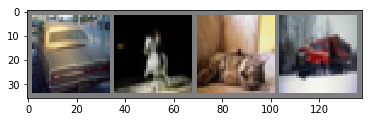

  car horse   cat truck


In [156]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [157]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.model_shapes = []
        self.init_params = []
        self.cuda = torch.cuda.is_available()
        

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    #From https://github.com/hardmaru/pytorch_notebooks/blob/master/mnist_es/pytorch_mnist_mini_es_cma.ipynb
    def get_flat_params(self):
        self.orig_params = []
        self.model_shapes = []
        for param in self.parameters():
            p = param.data.cpu().numpy()
            self.model_shapes.append(p.shape)
            self.orig_params.append(p.flatten())
            orig_params_flat = np.concatenate(self.orig_params)
            NPARAMS = len(orig_params_flat)
        return orig_params_flat, NPARAMS
    
    #From https://github.com/hardmaru/pytorch_notebooks/blob/master/mnist_es/pytorch_mnist_mini_es_cma.ipynb
    def set_params_from_flat(self, updated_params):
        idx = 0
        i = 0
        for param in self.parameters():
            delta = np.product(self.model_shapes[i])
            block = updated_params[idx:idx+delta]
            block = np.reshape(block, self.model_shapes[i])
            i += 1
            idx += delta
            block_data = torch.from_numpy(block).float()
            if self.cuda:
                block_data = block_data.cuda()
            param.data = block_data
            
            
net = Net()

In [158]:
def worker(procnum, model, solution, data, target, send_end):
  update_model(solution, model, model_shapes)
  output = model(data)
  loss = F.nll_loss(output, target)
  reward = - loss.data[0]
  send_end.send(reward)

def batch_simulation(model_list, solutions, data, target, process_count):
  jobs = []
  pipe_list = []

  for i in range(process_count):
    recv_end, send_end = mp.Pipe(False)
    p = mp.Process(target=worker, args=(i, model_list[i], solutions[i], data, target, send_end))
    jobs.append(p)
    pipe_list.append(recv_end)

  for p in jobs:
    p.start()

  for p in jobs:
    p.join()

  result_list = [x.recv() for x in pipe_list]
  return np.array(result_list)


def batch_simulation_sequential(model_list, solutions, data, target, process_count):
  result_list = []
  for i in range(process_count):
    update_model(solutions[i], model_list[i], model_shapes)
    output = model_list[i](data)
    loss = F.nll_loss(output, target)
    reward = - loss.data[0]
    result_list.append(reward)
  return np.array(result_list)

In [163]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [164]:
losses = []
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        losses.append(loss.item())
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.222
[1,  4000] loss: 1.894
[1,  6000] loss: 1.706
[1,  8000] loss: 1.612
[1, 10000] loss: 1.521
[1, 12000] loss: 1.476
[2,  2000] loss: 1.411
[2,  4000] loss: 1.376
[2,  6000] loss: 1.351
[2,  8000] loss: 1.313
[2, 10000] loss: 1.292
[2, 12000] loss: 1.277
Finished Training


In [178]:
import ipdb

In [181]:
def evaluate(model, test_loader, print_mode=True, return_loss=True):
  
  model.eval()
  test_loss = 0
  correct = 0
  for data, target in test_loader:
    if model.cuda:
      data, target = data.cuda(), target.cuda()
    output = model(data)
    test_loss += F.nll_loss(output, target, size_average=False).item() # sum up batch loss
    pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
    correct += pred.eq(target.data.view_as(pred)).cpu().sum()

  test_loss /= len(test_loader.dataset)
  acc = correct / len(test_loader.dataset)
  
  if print_mode:
    print('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * acc))
  
  if return_loss:
    return test_loss
  return acc

In [182]:
s = evaluate(net, testloader)


Average loss: -3.1504, Accuracy: 5491/10000 (0.0000%)



In [187]:
_,NPARAMS = net.get_flat_params()
NPOPULATION=50

In [ ]:
es = CMAES(NPARAMS, sigma_init=0.01, popsize=NPOPULATION)


In [ ]:
weight_decay_coef = 0.1

In [ ]:
#'''
best_valid_acc = 0
training_log = []
for epoch in range(1, 10*args.epochs + 1):

  # train loop
  model.eval()
  for batch_idx, (data, target) in enumerate(train_loader):
    if args.cuda:
      data, target = data.cuda(), target.cuda()
    data, target = Variable(data), Variable(target)
    
    solutions = es.ask()
    reward = np.zeros(es.popsize)
    
    for i in range(es.popsize):
      update_model(solutions[i], model, model_shapes)
      output = model(data)
      loss = F.nll_loss(output, target)
      reward[i] = - loss.data[0]

    best_raw_reward = reward.max()
    #reward = compute_centered_ranks(reward)
    #l2_decay = compute_weight_decay(weight_decay_coef, solutions)
    #reward += l2_decay

    es.tell(reward)

    result = es.result()
    
    if (batch_idx % 5 == 0):
      print(epoch, batch_idx, best_raw_reward, result[0].mean(), result[3].mean())

  curr_solution = es.current_param()
  update_model(curr_solution, model, model_shapes)

  valid_acc = evaluate(model, valid_loader, print_mode=False)
  training_log.append([epoch, valid_acc])
  print('valid_acc', valid_acc * 100.)
  if valid_acc >= best_valid_acc:
    best_valid_acc = valid_acc
    best_model = copy.deepcopy(model)
    print('best valid_acc', best_valid_acc * 100.)

In [12]:
mother_parameters = list(net.parameters())

In [14]:
mother_parameters

[Parameter containing:
 tensor([[[[ 2.8536e-01,  2.9684e-02,  1.7993e-01,  1.8062e-01, -4.6781e-02],
           [ 3.3868e-01,  2.5486e-01,  4.1222e-01,  1.1826e-01, -6.8439e-02],
           [-2.7536e-01, -3.0033e-01, -3.5438e-01, -2.0503e-01, -4.0115e-01],
           [-2.8794e-01, -4.7582e-01, -5.1809e-01, -3.3609e-01, -5.9490e-02],
           [ 1.1160e-01,  1.7833e-01,  4.8920e-01,  3.9455e-01,  2.6981e-01]],
 
          [[-2.8921e-02,  7.9719e-02,  2.4803e-01,  7.8614e-02, -1.0549e-02],
           [ 3.7643e-01,  1.6184e-01,  3.9776e-01,  7.6515e-02, -1.5096e-01],
           [-1.0312e-01, -3.8819e-01, -1.9676e-01, -3.5189e-01, -2.2062e-01],
           [-3.4544e-01, -3.8010e-01, -4.4561e-01, -3.3621e-01, -2.6908e-01],
           [ 1.3265e-01,  3.8116e-01,  3.5739e-01,  2.7017e-01, -1.6923e-02]],
 
          [[ 2.1301e-03, -2.1181e-01,  1.1898e-01, -7.7951e-02,  1.1496e-02],
           [ 2.2229e-01,  3.2847e-01,  3.0289e-01,  3.3793e-01,  9.4235e-02],
           [-4.0179e-02, -3.5081e-0

In [17]:
x= []                
for param in mother_parameters:
    x.append(param.data.size())

In [21]:
net.

<bound method Module.named_parameters of Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)>

In [20]:
[(k, v) for k, v in zip(net.state_dict().keys(),
                                       net.state_dict().values())]


[('conv1.weight',
  tensor([[[[ 2.8536e-01,  2.9684e-02,  1.7993e-01,  1.8062e-01, -4.6781e-02],
            [ 3.3868e-01,  2.5486e-01,  4.1222e-01,  1.1826e-01, -6.8439e-02],
            [-2.7536e-01, -3.0033e-01, -3.5438e-01, -2.0503e-01, -4.0115e-01],
            [-2.8794e-01, -4.7582e-01, -5.1809e-01, -3.3609e-01, -5.9490e-02],
            [ 1.1160e-01,  1.7833e-01,  4.8920e-01,  3.9455e-01,  2.6981e-01]],
  
           [[-2.8921e-02,  7.9719e-02,  2.4803e-01,  7.8614e-02, -1.0549e-02],
            [ 3.7643e-01,  1.6184e-01,  3.9776e-01,  7.6515e-02, -1.5096e-01],
            [-1.0312e-01, -3.8819e-01, -1.9676e-01, -3.5189e-01, -2.2062e-01],
            [-3.4544e-01, -3.8010e-01, -4.4561e-01, -3.3621e-01, -2.6908e-01],
            [ 1.3265e-01,  3.8116e-01,  3.5739e-01,  2.7017e-01, -1.6923e-02]],
  
           [[ 2.1301e-03, -2.1181e-01,  1.1898e-01, -7.7951e-02,  1.1496e-02],
            [ 2.2229e-01,  3.2847e-01,  3.0289e-01,  3.3793e-01,  9.4235e-02],
            [-4.0179e-02, 

In [23]:
# get init params
orig_params = []
model_shapes = []
for param in net.parameters():
  p = param.data.cpu().numpy()
  model_shapes.append(p.shape)
  orig_params.append(p.flatten())
orig_params_flat = np.concatenate(orig_params)
NPARAMS = len(orig_params_flat)
print(NPARAMS)

62006


In [37]:
len(orig_params_flat)

62006

In [27]:
model_shapes

[(6, 3, 5, 5),
 (6,),
 (16, 6, 5, 5),
 (16,),
 (120, 400),
 (120,),
 (84, 120),
 (84,),
 (10, 84),
 (10,)]

In [31]:
delta = np.product(model_shapes[0])

In [32]:
delta

450

In [38]:
block = orig_params_flat[0:450]
block = np.reshape(block, model_shapes[0])

In [41]:
block.shape

(6, 3, 5, 5)